### data setup

In [55]:
import pandas as pd
import numpy as np
import time
from scipy.optimize import differential_evolution as de

### functions

In [56]:
def theorical_temperature(data):
    initial_temperature = data.temperature.iloc[0]
    heating_rate = 5 # K/min
    return initial_temperature + (heating_rate/60) * data.time

def conversion(data):
    initial_mass = data.tga.iloc[0]
    final_mass = data.tga.iloc[-1]
    return (initial_mass - data.tga) / (initial_mass - final_mass)

def conversion_rate(order, data):
    return (1 - data.conversion)**order

def arrhenius(X, data):
    gas_constant = 8.314 # J/mol*K
    
    # print(f'x = \n{X}\n------------------')
    # print(f'RT = \n{gas_constant * data.theoretical_temperature}\n-----------')
    # print(f' -Ea/RT = \n{-X[1] / (gas_constant * data.theoretical_temperature)}\n-----------')
    # print(f' exp(-Ea/RT) = \n{np.exp( -X[1] / (gas_constant * data.theoretical_temperature))}\n-------')
    # print(f' Aexp(-Ea/RT) = \n{X[0] * np.exp( -X[1] / (gas_constant * data.theoretical_temperature))}\n---------')
    # print(f' (1-alpha)^n = \n{conversion_rate(X[2], data)}\n------------')

    return X[0] * np.exp( -X[1] / (gas_constant * data.theoretical_temperature)) * conversion_rate(X[2], data)

def rpi_model_for_mass(X, data):
    return X[0] * arrhenius(X[1:], data)

def objective_function(X, data):
    # Decoupling the parameters make it easier to work them out
    hemicellulose_params = X[:4]
    cellulose_params = X[4:8]
    lignin_params = X[8:]

    model_hemicellulose = rpi_model_for_mass(hemicellulose_params, data)
    model_cellulose = rpi_model_for_mass(cellulose_params, data)
    model_lignin = rpi_model_for_mass(lignin_params, data)

    complete_model = model_hemicellulose + model_cellulose + model_lignin

    data['model_hemicellulose'] = model_hemicellulose
    data['model_cellulose'] = model_cellulose
    data['model_lignin'] = model_lignin
    data['RPI_model'] = complete_model
    data['err'] = (data['RPI_model'] - data['dtga'])**2
    
    # the sum returned is needed for the DE optimization
    return data.err.sum()
    

### main function

In [71]:
data = pd.read_csv('dados\MC carpel H 5-min.csv')
data.dtga = -1 * data.dtga
data = data.drop('dtga_5', axis=1)
data['conversion'] = conversion(data)
data['theoretical_temperature'] = theorical_temperature(data)

# initial guess based on previous runs and the literature
hemicellulose = [0.09830400000000002, 9699428.75414291, 126345.86032457817, 2.0380173224446687]
cellulose = [0.2078939242040448, 6773901549.759028, 176523.95836263048, 1.5486633385322992]
lignin = [0.09830400000000002, 327.68000000000006, 24883.2, 7.464959999999998]

# Function value: 0.8436237676293329

# Bounds follows: [(component_fraction), (pre_exp_factor), (activation_energy), (order)]
range_lower = 0.8
range_upper = 1.2

hemicellulose = [(range_lower * hemicellulose[0], range_upper * hemicellulose[0]), 
                 (range_lower * hemicellulose[1], range_upper * hemicellulose[1]),
                 (range_lower * hemicellulose[2], range_upper * hemicellulose[2]),
                 (range_lower * hemicellulose[3], range_upper * hemicellulose[3])
                 ]

cellulose = [(range_lower * cellulose[0], range_upper * cellulose[0]), 
             (range_lower * cellulose[1], range_upper * cellulose[1]),
             (range_lower * cellulose[2], range_upper * cellulose[2]),
             (range_lower * cellulose[3], range_upper * cellulose[3])
             ]

lignin = [(range_lower * lignin[0], range_upper * lignin[0]), 
          (range_lower * lignin[1], range_upper * lignin[1]),
          (range_lower * lignin[2], range_upper * lignin[2]),
          (range_lower * lignin[3], range_upper * lignin[3])
          ]

bounds = hemicellulose + cellulose + lignin

# # DE hyper-parameters
# strategy = 'best1bin'
# maxiter = 1000
# popsize = 15
# tol = 1e-2
# mutation = (0.5, 1)
# recombination = 0.7

initial_time = time.time()

results = de(objective_function, 
            bounds = bounds,
            args = (data, ),
            )

final_time = time.time()
elapsed_time = final_time - initial_time
print(f'Time elapsed: {elapsed_time} seconds.\n')

params = results.x
opt_fun = results.fun
results_hemicellulose = params[:4]
results_cellulose = params[4:8]
results_lignin = params[8:]

print(f"""Results:
------------------------------------------
hemicellulose = {list(results_hemicellulose)}
cellulose = {list(results_cellulose)}
lignin = {list(results_lignin)}

# Function value: {opt_fun}
------------------------------------------
""")

model_hemicellulose = rpi_model_for_mass(results_hemicellulose, data)
model_cellulose = rpi_model_for_mass(results_cellulose, data)
model_lignin = rpi_model_for_mass(results_lignin, data)

complete_model = model_hemicellulose + model_cellulose + model_lignin

data['model_hemicellulose'] = model_hemicellulose
data['model_cellulose'] = model_cellulose
data['model_lignin'] = model_lignin
data['RPI_model'] = complete_model
data['err'] = (data['RPI_model'] - data['dtga'])**2

Time elapsed: 23.86656951904297 seconds.

Results:
------------------------------------------
hemicellulose = [0.11796480000000001, 9462786.571058348, 102748.59160863618, 1.630413857955735]
cellulose = [0.24947270904485375, 6182763749.242363, 170818.34432411258, 1.5619699492742238]
lignin = [0.07864320000000002, 262.14400000000006, 29859.84, 8.957951999999997]

# Function value: 0.02731190588964096
------------------------------------------



In [73]:
data.head(5)

,time,temperature,tga,dtga,conversion,theoretical_temperature,model_hemicellulose,model_cellulose,model_lignin,RPI_model,err
0,0,450.35,10.32687,0.000092,0.000000,450.350000,0.000001,2.370406e-11,0.007091,0.007093,0.000049
1,5,450.85,10.32643,0.000088,0.000066,450.766667,0.000001,2.472252e-11,0.007140,0.007141,0.000050
2,10,451.25,10.32595,0.000096,0.000137,451.183333,0.000001,2.578249e-11,0.007188,0.007189,0.000050
3,15,451.65,10.32550,0.000090,0.000205,451.600000,0.000001,2.688600e-11,0.007236,0.007238,0.000051
4,20,452.15,10.32502,0.000096,0.000276,452.016667,0.000001,2.803437e-11,0.007285,0.007286,0.000052


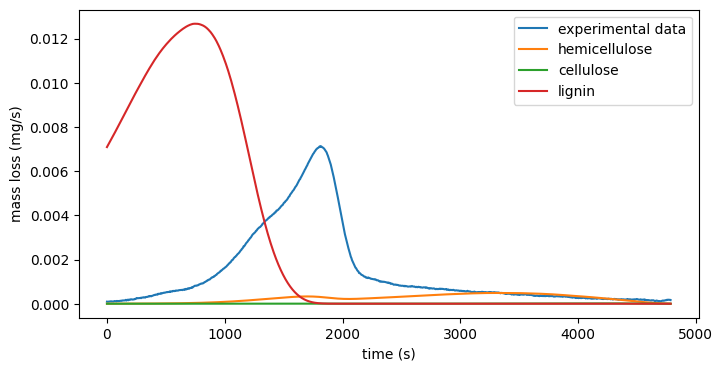

In [72]:
data.plot(x='time',
            y=['dtga','model_hemicellulose', 'model_cellulose', 'model_lignin'],
            kind='line',
            figsize=(8,4),
            label=['experimental data', 'hemicellulose', 'cellulose', 'lignin'],
            xlabel='time (s)',
            ylabel='mass loss (mg/s)');